## Machine Learning 

1. Helper Function + Import Libraries
2. Random Forest 
- Random Forest 
- Random Forest + SMOTE
3. XGBoost 
- XGBoost 
- XGBoost + SMOTE
- XGBoost + Calibrated Probabilities 
- XGBoost + Calibrated Probabilities (Set recall for Class 0 threshold to 80%)
4. K-Nearest Neighbours 
- K-Nearest Neighbours 
- K-Nearest Neighbours + SMOTE 
- K-Nearest Neighbours + Tuning 
- K-Nearest Neighbours (Confidence of Model)



## 1. Helper Function + Import Libraries

In [62]:
#HELPER FUNCTION 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    """
    Prints:
      - Confusion matrix
      - Precision/Recall/F1 for each class (0, 1, …)
    """
    # 1) Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # 2) Per-class metrics
    labels = sorted(set(y_true))
    for lbl in labels:
        p = precision_score(y_true, y_pred, pos_label=lbl)
        r = recall_score(y_true, y_pred, pos_label=lbl)
        f = f1_score(y_true, y_pred, pos_label=lbl)
        print(f"\nClass {lbl} — Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}")

# Whatever u need to import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier


credit_data = pd.read_csv('cleaned-dataset.csv', index_col=0)
numerical_columns = [
    'Current Loan Amount', 'Credit Score', 'Annual Income',
    'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts',
    'Number of Credit Problems', 'Current Credit Balance',
    'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'
]
categorical_columns = [
    'Term', 'Years in current job', 'Home Ownership', 'Purpose'
]


## 2. Random Forest

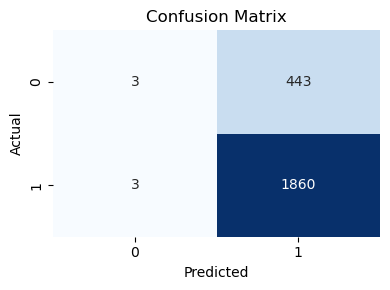


Class 0 — Precision: 0.5000, Recall: 0.0067, F1: 0.0133

Class 1 — Precision: 0.8076, Recall: 0.9984, F1: 0.8929


In [63]:
# a. Random Forest

# 1) Prepare X and y
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']

# 2) Encode the target labels to 0/1
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3) Build preprocessing transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 4) Assemble pipeline with Random Forest
rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(
        n_estimators=100,          # number of trees
        max_depth=None,            # nodes are expanded until all leaves are pure
        class_weight='balanced',   # handle class imbalance automatically
        random_state=42
    ))
])

# 5) Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# 6) Fit and evaluate
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

evaluate_model(y_test, y_pred)


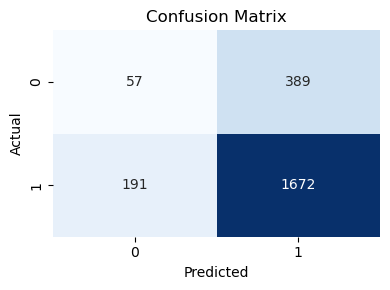


Class 0 — Precision: 0.2298, Recall: 0.1278, F1: 0.1643

Class 1 — Precision: 0.8113, Recall: 0.8975, F1: 0.8522


In [64]:
# b. Random Forest + SMOTE

# 1) Prepare X and y
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2) Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# 3) Build the preprocessing transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 4) Assemble SMOTE + Random Forest pipeline
rf_smote_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),  # balance classes 1:1
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42
    ))
])

# 5) Fit the pipeline and evaluate
rf_smote_pipe.fit(X_train, y_train)
y_pred = rf_smote_pipe.predict(X_test)

evaluate_model(y_test, y_pred)


## 3. XGBoost

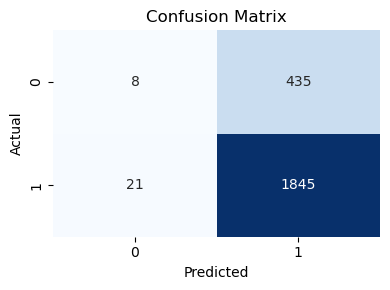


Class 0 — Precision: 0.2759, Recall: 0.0181, F1: 0.0339

Class 1 — Precision: 0.8092, Recall: 0.9887, F1: 0.8900


In [65]:
# a. XGBoost 

# 1) Prepare X and y
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']

# 2) Encode the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3) Build the preprocessing + XGBoost pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='logloss',
        random_state=42
    ))
])

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# 5) Fit
xgb_pipeline.fit(X_train, y_train)

# 6) Predict & evaluate
y_pred = xgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred)


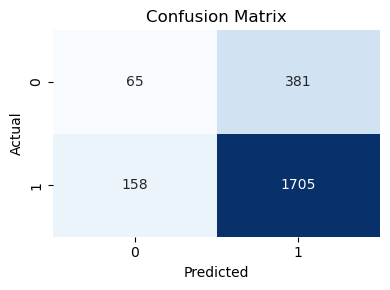


Class 0 — Precision: 0.2915, Recall: 0.1457, F1: 0.1943

Class 1 — Precision: 0.8174, Recall: 0.9152, F1: 0.8635


In [66]:

# b. XGBoost + SMOTE

# 1) Prepare X and y
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']

# 2) Encode the target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4) Build preprocessing transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 5) SMOTE + XGBoost pipeline
xgb_smote_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),  # 1:1 oversampling
    ('xgb', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ))
])

# 6) Fit and evaluate
xgb_smote_pipe.fit(X_train, y_train)
y_pred = xgb_smote_pipe.predict(X_test)

evaluate_model(y_test, y_pred)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'xgb__subsample': 0.6, 'xgb__scale_pos_weight': 0.2395227442207308, 'xgb__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.05, 'xgb__gamma': 5, 'xgb__colsample_bytree': 0.6}


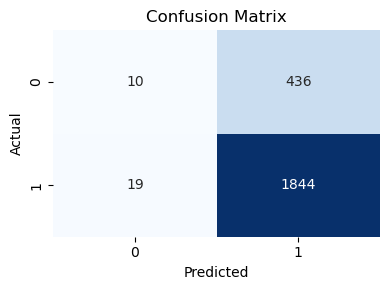


Class 0 — Precision: 0.3448, Recall: 0.0224, F1: 0.0421

Class 1 — Precision: 0.8088, Recall: 0.9898, F1: 0.8902


In [67]:
# XGBoost + Calibrated Probabilities 

# 1) Prepare X/y and encode target
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']
le = LabelEncoder()
y = le.fit_transform(y)

# 2) Split into train_full/test, then train/val (val only for calibration)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1,
    random_state=42, stratify=y_train_full
)

# 3) Compute imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# 4) Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 5) Hyperparameter search pipeline
search_pipe = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ))
])
param_dist = {
    'xgb__n_estimators':      [100, 200, 300],
    'xgb__learning_rate':     [0.01, 0.05, 0.1],
    'xgb__max_depth':         [4, 6, 8],
    'xgb__subsample':         [0.6, 0.8, 1.0],
    'xgb__colsample_bytree':  [0.6, 0.8, 1.0],
    'xgb__gamma':             [0, 1, 5],
    'xgb__scale_pos_weight':  [ratio]
}
rs = RandomizedSearchCV(
    search_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs.fit(X_train, y_train)
best = rs.best_params_
print("Best hyperparameters:", best)

# 6) Build final XGB (no early stopping)
xgb_final = XGBClassifier(
    n_estimators=1000,
    learning_rate=best['xgb__learning_rate'],
    max_depth=best['xgb__max_depth'],
    subsample=best['xgb__subsample'],
    colsample_bytree=best['xgb__colsample_bytree'],
    gamma=best['xgb__gamma'],
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=42
)

# Preprocess datasets
X_tr = preprocessor.fit_transform(X_train)
X_va = preprocessor.transform(X_val)
X_te = preprocessor.transform(X_test)

# Train model on training set
xgb_final.fit(X_tr, y_train)

# 7) Calibrate model
calib = CalibratedClassifierCV(xgb_final, cv='prefit', method='isotonic')
calib.fit(X_va, y_val)

# 8) Predict directly with default threshold (0.5)
y_pred = calib.predict(X_te)

# 9) Evaluate predictions
evaluate_model(y_test, y_pred)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparams: {'xgb__subsample': 0.6, 'xgb__scale_pos_weight': 0.2395227442207308, 'xgb__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.05, 'xgb__gamma': 5, 'xgb__colsample_bytree': 0.6}
Threshold for ≥80% class 0 recall: 0.840 (Recall_0=0.982)


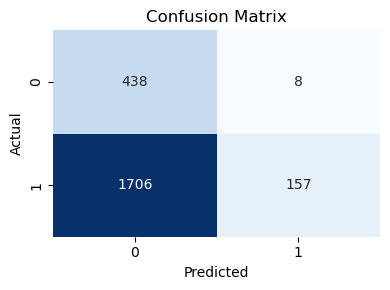


Class 0 — Precision: 0.2043, Recall: 0.9821, F1: 0.3382

Class 1 — Precision: 0.9515, Recall: 0.0843, F1: 0.1548


In [68]:

# XGBoost + Calibrated Probabilities (Set recall threshold for class 0 to 80%)

# 1) Prepare X/y and encode target
X = credit_data[numerical_columns + categorical_columns]
y = credit_data['Loan Status']
le = LabelEncoder()
y = le.fit_transform(y)

# 2) Split into train_full/test, then train/val (val only for calibration)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1,
    random_state=42, stratify=y_train_full
)

# 3) Compute imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# 4) Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 5) Hyperparameter search pipeline
search_pipe = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBClassifier(
        # use_label_encoder removed
        eval_metric='logloss',
        random_state=42
    ))
])
param_dist = {
    'xgb__n_estimators':      [100, 200, 300],
    'xgb__learning_rate':     [0.01, 0.05, 0.1],
    'xgb__max_depth':         [4, 6, 8],
    'xgb__subsample':         [0.6, 0.8, 1.0],
    'xgb__colsample_bytree':  [0.6, 0.8, 1.0],
    'xgb__gamma':             [0, 1, 5],
    'xgb__scale_pos_weight':  [ratio]
}
rs = RandomizedSearchCV(
    search_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs.fit(X_train, y_train)
best = rs.best_params_
print("Best hyperparams:", best)

# 6) Build final XGB (no early stopping)
xgb_final = XGBClassifier(
    n_estimators=1000,
    learning_rate=best['xgb__learning_rate'],
    max_depth=best['xgb__max_depth'],
    subsample=best['xgb__subsample'],
    colsample_bytree=best['xgb__colsample_bytree'],
    gamma=best['xgb__gamma'],
    scale_pos_weight=ratio,
    # use_label_encoder removed
    eval_metric='logloss',
    random_state=42
)

# Preprocess once
X_tr = preprocessor.fit_transform(X_train)
X_va = preprocessor.transform(X_val)
X_te = preprocessor.transform(X_test)

# Train on all of X_tr
xgb_final.fit(X_tr, y_train)

# 7) Calibrate on the val set
calib = CalibratedClassifierCV(xgb_final, cv='prefit', method='isotonic')
calib.fit(X_va, y_val)

# 8) Pick threshold for ≥80% recall on class 0
probs = calib.predict_proba(X_te)[:, 1]
best_thr = None
for thr in np.linspace(0, 1, 101):
    preds = (probs >= thr).astype(int)
    rec0 = recall_score(y_test, preds, pos_label=0)
    if rec0 >= 0.80:
        best_thr = thr
        break

if best_thr is None:
    print("No threshold achieves 80% recall on class 0 in [0,1].")
else:
    print(f"Threshold for ≥80% class 0 recall: {best_thr:.3f} (Recall_0={rec0:.3f})")

    # 9) Final evaluation at that threshold
    y_pred = (probs >= best_thr).astype(int)
    evaluate_model(y_test, y_pred)


 ## 4. K-Nearest Neighbours


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best KNN params: {'knn__n_neighbors': 11, 'knn__weights': 'distance'}


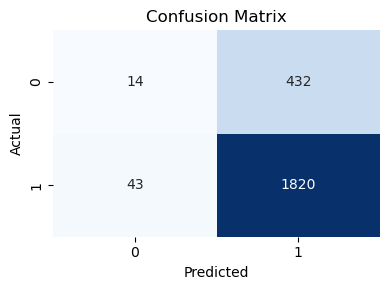


Class 0 — Precision: 0.2456, Recall: 0.0314, F1: 0.0557

Class 1 — Precision: 0.8082, Recall: 0.9769, F1: 0.8846



ROC AUC (probabilities): 0.5270490481382792


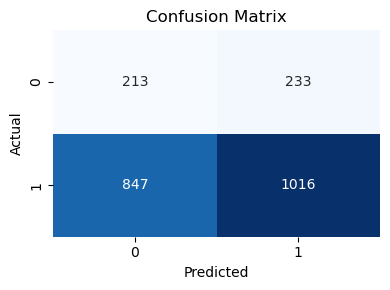


Class 0 — Precision: 0.2009, Recall: 0.4776, F1: 0.2829

Class 1 — Precision: 0.8135, Recall: 0.5454, F1: 0.6530


In [69]:
# K-Nearest Neighbours

# 1) Prepare X/y
X = credit_data[numerical_columns + categorical_columns]
y = LabelEncoder().fit_transform(credit_data['Loan Status'])

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Preprocessing transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
])

# 4) Build a pipeline with KNN
knn_pipe = Pipeline([
    ('preproc', preprocessor),
    ('knn', KNeighborsClassifier())
])

# 5) Hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}

grid = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 6) Fit & select best
grid.fit(X_train, y_train)
print("Best KNN params:", grid.best_params_)

best_knn = grid.best_estimator_

# 7) Predict & evaluate
y_pred = best_knn.predict(X_test)
evaluate_model(y_test, y_pred)
print("\n\n")

# optional, roc_auc tells us how clearly the two are separated 
from sklearn.metrics import roc_auc_score
print("ROC AUC (probabilities):", roc_auc_score(y_test, y_proba))

# optional, instead of flagging them as risky at default 0.5, flag them at 0.7 
# this reduces false positives (which idt is our case)
risky_flags = (y_proba > 0.7).astype(int)
evaluate_model(y_test, risky_flags)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'uniform'}


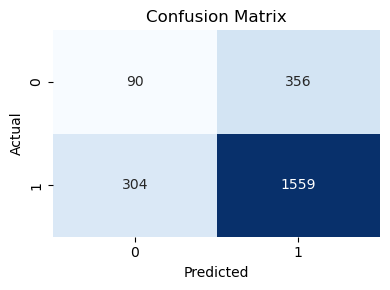


Class 0 — Precision: 0.2284, Recall: 0.2018, F1: 0.2143

Class 1 — Precision: 0.8141, Recall: 0.8368, F1: 0.8253


In [70]:
# K-Nearest Neighbours + SMOTE

# build an imbalanced‐learn pipeline
imb_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [5, 11, 17],
    'knn__weights':      ['uniform','distance'],
    'knn__p':            [1,2]       # try Manhattan vs Euclidean
}

grid = GridSearchCV(
    imb_pipe,
    param_grid,
    cv=5,
    scoring='recall',        # by default this is recall of the POS label=1
    n_jobs=-1, 
    verbose=1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
evaluate_model(y_test, y_pred)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}


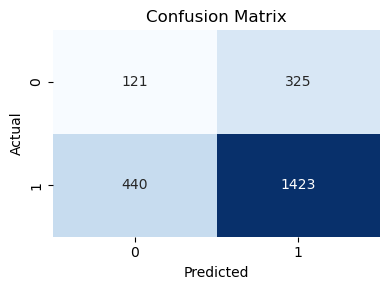


Class 0 — Precision: 0.2157, Recall: 0.2713, F1: 0.2403

Class 1 — Precision: 0.8141, Recall: 0.7638, F1: 0.7881


In [71]:

# KNN + Tuning

# We tune on 
# optimisation for recall for class 0
# PCA for dimensionality reduction
# SMOTE + remove any borderline noise that will confuse the model
# GridSearchCV


# 1) scorer that optimizes recall on the charged-off class (label=0)
recall_0 = make_scorer(recall_score, pos_label=0)

# 2) build pipeline: scale & encode → PCA → SMOTETomek → KNN
knn_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('pca', PCA(n_components=10)),                   # reduce to 10 dims
    ('resample', SMOTETomek(sampling_strategy=0.5,   # 50/50 in train folds
                             random_state=42)),
    ('knn', KNeighborsClassifier())
])

# 3) hyperparameter grid for KNN
param_grid = {
    'knn__n_neighbors': [5, 11, 17],
    'knn__weights':      ['uniform', 'distance'],
    'knn__p':            [1, 2]
}

# 4) grid search optimizing class‑0 recall
grid = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    cv=5,
    scoring=recall_0,
    n_jobs=-1,
    verbose=1
)

# 5) fit & select best
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_knn = grid.best_estimator_

# 6) predict on the real-world (imbalanced) test set
y_pred = best_knn.predict(X_test)

# 7) evaluate with your helper
evaluate_model(y_test, y_pred)


Total predictions: 2309
Predicted to Default (label=1): 1748
Predicted NOT to Default (label=0): 561

Breakdown of 'Predicted to Default':
 prob_range
0–20%         0
20–40%        0
40–60%      173
60–80%      419
80–100%    1156
Name: count, dtype: int64

Breakdown of 'Predicted NOT to Default':
 prob_range
0–20%      140
20–40%     230
40–60%     191
60–80%       0
80–100%      0
Name: count, dtype: int64

Total from both pie charts: 2309


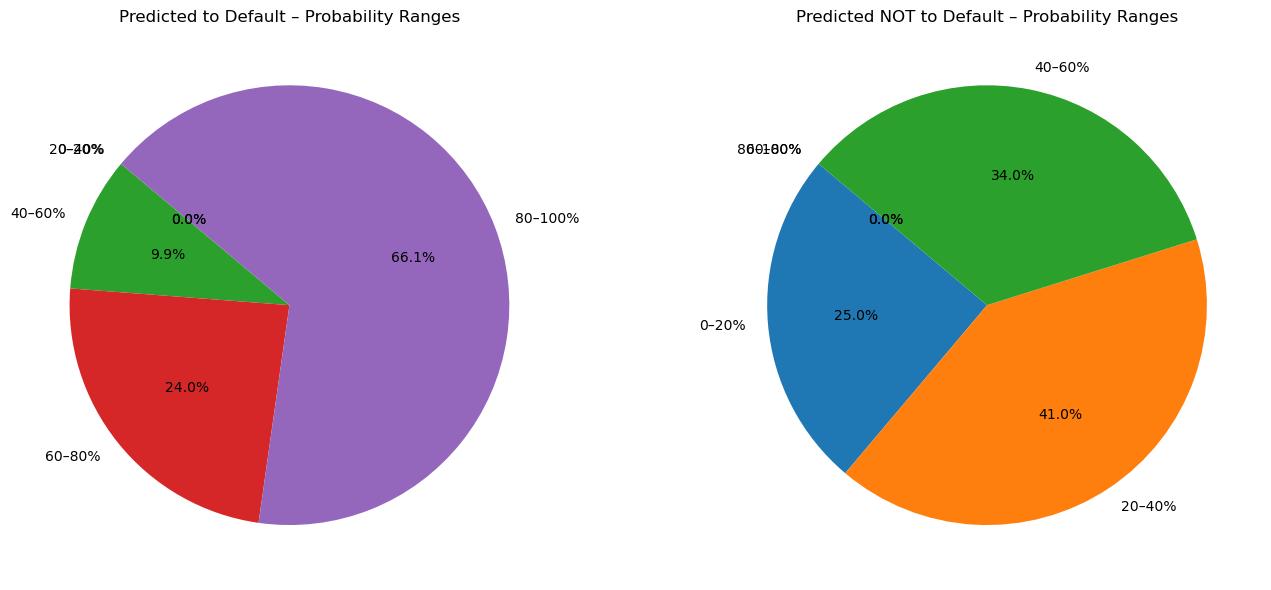

In [72]:
# Confidence level 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get probabilities and predictions
y_proba = best_knn.predict_proba(X_test)[:, 1]
y_pred = best_knn.predict(X_test)

# Combine into a DataFrame
df = pd.DataFrame({
    'predicted_label': y_pred,
    'prob_default': y_proba
})

# Define probability bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0–20%', '20–40%', '40–60%', '60–80%', '80–100%']

# Fix: Include lowest and make right edge inclusive
df['prob_range'] = pd.cut(
    df['prob_default'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

# Count bin distribution for each predicted label
default_counts = df[df['predicted_label'] == 1]['prob_range'].value_counts().sort_index()
no_default_counts = df[df['predicted_label'] == 0]['prob_range'].value_counts().sort_index()

# ==== Sanity checks ====
print("Total predictions:", len(df))
print("Predicted to Default (label=1):", len(df[df['predicted_label'] == 1]))
print("Predicted NOT to Default (label=0):", len(df[df['predicted_label'] == 0]))
print("\nBreakdown of 'Predicted to Default':\n", default_counts)
print("\nBreakdown of 'Predicted NOT to Default':\n", no_default_counts)
print("\nTotal from both pie charts:", default_counts.sum() + no_default_counts.sum())

# Plot pie chart: Predicted Default
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.pie(default_counts, labels=default_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Predicted to Default – Probability Ranges')

# Plot pie chart: Predicted No Default
plt.subplot(1, 2, 2)
plt.pie(no_default_counts, labels=no_default_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Predicted NOT to Default – Probability Ranges')

plt.tight_layout()
plt.show()
